# 统计年龄样本的分布情况

--- 开始执行数据可视化任务 ---
✅ 成功加载已过滤的元数据，包含 32179 个样本。

📈 正在计算年龄分布统计信息...

--- 年龄分布概要 ---
count    32179.000000
mean        42.366407
std         19.304509
min          0.000000
25%         29.900000
50%         43.200000
75%         57.600000
max        100.000000
Name: age, dtype: float64
----------------------

🎨 正在生成年龄分布图...
✅ 年龄分布图已成功保存至 'Figures/age_distribution_plot.png'


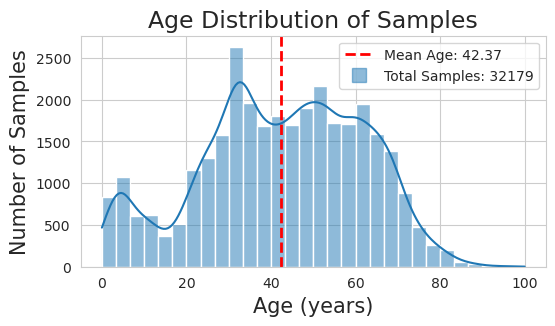


🏁 数据可视化脚本执行完毕。


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 配置 ---
# 设置已过滤文件的路径（由脚本一生成）
FILTERED_METADATA_PATH = 'Data/age_prediction_data/metadata.tsv'

# 设置图表的输出目录和文件名
OUTPUT_DIRECTORY = 'Figures'
PLOT_OUTPUT_PATH = os.path.join(OUTPUT_DIRECTORY, 'age_distribution_plot.png')


# --- 主绘图逻辑 ---
def main():
    """主函数，加载过滤后的数据并生成图表"""
    print("--- 开始执行数据可视化任务 ---")

    # 设置绘图样式
    sns.set_style("whitegrid")
    
    # 加载已过滤的元数据
    try:
        metadata_df = pd.read_csv(FILTERED_METADATA_PATH, sep='\t', index_col='sample')
        print(f"✅ 成功加载已过滤的元数据，包含 {len(metadata_df)} 个样本。")
    except FileNotFoundError:
        print(f"❌ 文件未找到错误: '{FILTERED_METADATA_PATH}'。")
        print("   请先运行数据筛选脚本 (filter_and_save_data.py) 来生成此文件。")
        return
    except Exception as e:
        print(f"❌ 加载过滤后的元数据文件出错: {e}")
        return

    # 检查用于绘图的 'Age_numeric' 列是否存在
    age_column = 'age'
    if age_column not in metadata_df.columns:
        print(f"⚠️ 在元数据中未找到 '{age_column}' 列。无法生成年龄分布图。")
        return

    # --- 计算统计信息并绘图 ---
    print("\n📈 正在计算年龄分布统计信息...")
    age_stats = metadata_df[age_column].describe()
    print("\n--- 年龄分布概要 ---")
    print(age_stats)
    print("----------------------")

    print("\n🎨 正在生成年龄分布图...")
    
    # --- 修改部分开始 ---

    # 1. 创建一个 Figure 和 Axes 对象，这让我们能更好地控制图表元素
    fig, ax = plt.subplots(figsize=(6, 3))

    # 2. 在指定的 Axes (ax) 上绘制直方图
    sns.histplot(data=metadata_df, x=age_column, kde=True, bins=30, ax=ax)
    
    # 3. 从绘制好的直方图中获取其颜色
    # ax.patches 包含了图上所有的矩形块（即柱子）
    # 我们取第一个柱子的表面颜色作为代表色
    hist_color = ax.patches[0].get_facecolor()

    # 设置图表标题和标签 (注意现在用 ax.set_... 代替 plt....)
    ax.set_title('Age Distribution of Samples', fontsize=17, )
    ax.set_xlabel('Age (years)', fontsize=15)
    ax.set_ylabel('Number of Samples', fontsize=15)

    # 4. 单独为红色均值线创建图例
    mean_age = metadata_df[age_column].mean()
    mean_label = f'Mean Age: {mean_age:.2f}'
    ax.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=mean_label)

    # 5. 使用从直方图获取的颜色 (hist_color) 来创建总样本数的图例
    sample_count = len(metadata_df)
    sample_label = f'Total Samples: {sample_count}'
    ax.plot([], [], marker='s', color=hist_color, linestyle='none', markersize=10, label=sample_label)

    # 6. 显示图例
    ax.legend()
    
    # --- 修改部分结束 ---
    
    # 保存图表到文件
    try:
        os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)
        # 保存整个 figure 对象
        fig.savefig(PLOT_OUTPUT_PATH)
        print(f"✅ 年龄分布图已成功保存至 '{PLOT_OUTPUT_PATH}'")
    except Exception as e:
        print(f"❌ 保存图表失败: {e}")
        
    plt.show() # 显示图表

    print("\n🏁 数据可视化脚本执行完毕。")

if __name__ == '__main__':
    main()

# 获取年龄分布的结果

In [4]:
import torch
import biom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_absolute_error, r2_score, accuracy_score
from membed.Attention_embedding import load_data_imdb, DataLoader, TransformerEncoder, evaluate_auc_gpu, set_seed

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


membed 0.1.0 initialized.


In [5]:
set_seed(11)
num_steps=600
p_drop=0.4
batch_size=25000
d_model=100
n_layers=1
n_heads=1
group = "age"

In [7]:

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from biom import load_table
 
# 配置路径
base_dir = "Data/age_prediction_data"
 
# 初始化结果容器
results = {
    'disease': [], 'test_study': [], 'r2': [], 'mae': [],
    'mse': [], 'rmse': []
}

def evaluate_regression(y_true, y_pred):
    """
    Calcula las métricas de rendimiento para una tarea de regresión.

    Args:
        y_true (torch.Tensor): Tensor con los valores reales (verdaderos).
        y_pred (torch.Tensor): Tensor con los valores predichos por el modelo.

    Returns:
        tuple: Una tupla que contiene (R-cuadrado, MAE, MSE, RMSE).
    """
    # Mover los tensores a la CPU y convertirlos a arrays de NumPy
    y_true_np = y_true.cpu().numpy().flatten()
    y_pred_np = y_pred.cpu().detach().numpy().flatten()

    # Calcular las métricas de regresión
    r2 = r2_score(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse) # RMSE es la raíz cuadrada de MSE

    print(f"  -> Métricas de Evaluación: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    return r2, mae, mse, rmse

def save_regression_predictions(sample_ids, true_values, predicted_values, output_dir, filename="predictions.csv"):
    """
    Guarda los IDs de muestra, los valores reales y los valores predichos en un archivo CSV.

    Args:
        sample_ids (list or np.array): Una lista o array con los identificadores de las muestras.
        true_values (np.array): Un array con los valores reales (edad).
        predicted_values (np.array): Un array con los valores predichos por el modelo.
        output_dir (str): El directorio donde se guardará el archivo.
        filename (str): El nombre del archivo CSV de salida.
    """
    # Asegurarse de que el directorio de salida exista
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)

    # Comprobar la consistencia de las longitudes de los arrays
    if not (len(sample_ids) == len(true_values) == len(predicted_values)):
        print(f"!! ERROR: Inconsistencia en las longitudes de los datos. No se puede guardar el archivo.")
        print(f"   - IDs de muestra: {len(sample_ids)}")
        print(f"   - Valores reales: {len(true_values)}")
        print(f"   - Valores predichos: {len(predicted_values)}")
        return

    # Crear un DataFrame de pandas con los datos
    predictions_df = pd.DataFrame({
        'SampleID': sample_ids,
        'TrueValue': true_values,
        'PredictedValue': predicted_values
    })

    # Guardar el DataFrame en un archivo CSV sin el índice
    predictions_df.to_csv(output_path, index=False, float_format='%.6f')
    print(f"√ Predicciones guardadas exitosamente en: {output_path}")
 
def process_disease(disease_path):
    """处理单个疾病目录"""
    disease_name = os.path.basename(disease_path)
    print(f"\n{'='*30}\n处理疾病: {disease_name}\n{'='*30}")
    
    # 获取所有研究目录
    study_dirs = [
        d for d in os.listdir(disease_path) 
        if os.path.isdir(os.path.join(disease_path, d))
    ]
    
    # 跳过单个研究的疾病
    if len(study_dirs) <= 1:
        print(f"!! 跳过 {disease_name}，仅有 {len(study_dirs)} 个研究")
        return

    
    # 检查元数据文件
    metadata_path = os.path.join(disease_path, "metadata.tsv")
    if not os.path.exists(metadata_path):
        print(f"!! 严重错误：{disease_name} 缺失元数据文件")
        return
    
    # 遍历每个研究
    for study in study_dirs:
        study_path = os.path.join(disease_path, study)
        print(f"\n-- 处理研究: {study}")
        
        # 验证必需文件
        required_files = {
            'train': 'train_loo.biom',
            'test': 'test_loo.biom',
            'model': os.path.join('results', 'attention_loo.pt')
        }
        
        missing_files = [
            f for f in required_files.values() 
            if not os.path.exists(os.path.join(study_path, f))
        ]
        
        if missing_files:
            print(f"!! 文件缺失: {', '.join(missing_files)}")
            continue
        

        # 加载数据
        train_data = load_data_imdb(f'{study_path}/train_loo.biom',
                                    metadata_path,
                                    group,
                                    'sample',
                                    num_steps)
        test_data = load_data_imdb(f'{study_path}/test_loo.biom',
                                        metadata_path,
                                        group,
                                        'sample',
                                        num_steps)
        
        train_iter = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        test_iter = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        table = biom.load_table(f'{study_path}/test_loo.biom')
        study_ordered_sample_ids = table.ids(axis='sample')
        
        # 加载模型
        fid_dict = train_data()
        net = TransformerEncoder(otu_size=len(fid_dict),
                                    seq_len=num_steps+1,
                                    d_model=d_model,
                                    n_layers=n_layers,
                                    n_heads=n_heads,
                                    p_drop=p_drop,
                                    pad_id=fid_dict['<pad>'])
        
        net.load_state_dict( 
                torch.load(
                    f'{study_path}/results/attention_loo.pt',
                    map_location=torch.device('cpu')))
        
        print(net.embedding)  # 确认num_embeddings参数
        
        with torch.no_grad():
            net.eval()
            # Para regresión, es mejor procesar todos los datos de prueba a la vez si la memoria lo permite
            # Esto evita problemas con lotes (batches) de tamaño 1
            all_preds = []
            all_labels = []
            for features, abundance, group_lables, mask in test_iter:
                pred, _ = net(features, abundance, mask)
                all_preds.append(pred)
                all_labels.append(group_lables)

            # Concatenar los resultados de todos los lotes
            final_preds = torch.cat(all_preds)
            final_true_labels = torch.cat(all_labels)

            # 1. EVALUAR EL MODELO con la nueva función
            r2, mae, mse, rmse = evaluate_regression(final_true_labels, final_preds)
            
            # 2. GUARDAR LAS PREDICCIONES con la nueva función
            output_dir = os.path.join(base_dir, disease_name, study, "results")
            save_regression_predictions(
                sample_ids=study_ordered_sample_ids,
                true_values=final_true_labels.cpu().numpy().flatten(),
                predicted_values=final_preds.cpu().detach().numpy().flatten(),
                output_dir=output_dir,
                filename="age_predictions.csv" # Un nombre de archivo más descriptivo
            )

            # 3. GUARDAR LOS RESULTADOS DE LAS MÉTRICAS (actualizado para regresión)
            results['disease'].append(disease_name)
            results['test_study'].append(study)
            results['r2'].append(r2)
            results['mae'].append(mae)
            results['mse'].append(mse)
            results['rmse'].append(rmse)
            print(f"√ Resultados de la eval")
        

for disease_folder in os.listdir(base_dir):
    disease_path = os.path.join(base_dir, disease_folder)
    if os.path.isdir(disease_path):
        process_disease(disease_path)

# 汇总结果
summary_df = pd.DataFrame(results)
summary_path = os.path.join( "Data/age_prediction_data/attention_results.csv")
summary_df.to_csv(summary_path, index=False)



处理疾病: all_study



-- 处理研究: PRJNA579996
Embedding(14119, 100, padding_idx=1)
  -> Métricas de Evaluación: R²=-4.6825, MAE=16.5451, RMSE=19.1717
√ Predicciones guardadas exitosamente en: Data/age_prediction_data/all_study/PRJNA579996/results/age_predictions.csv
√ Resultados de la eval

-- 处理研究: PRJNA532645
Embedding(14119, 100, padding_idx=1)
  -> Métricas de Evaluación: R²=0.0021, MAE=3.3840, RMSE=5.2353
√ Predicciones guardadas exitosamente en: Data/age_prediction_data/all_study/PRJNA532645/results/age_predictions.csv
√ Resultados de la eval

-- 处理研究: PRJNA644763
Embedding(14119, 100, padding_idx=1)
  -> Métricas de Evaluación: R²=-0.1514, MAE=0.7985, RMSE=1.0616
√ Predicciones guardadas exitosamente en: Data/age_prediction_data/all_study/PRJNA644763/results/age_predictions.csv
√ Resultados de la eval

-- 处理研究: qiita_2639
Embedding(14119, 100, padding_idx=1)
  -> Métricas de Evaluación: R²=-0.1540, MAE=7.7735, RMSE=10.8588
√ Predicciones guardadas exitosamente en: Data/age_prediction_data/all_study/qii

In [ ]:
import re
from pathlib import Path
import pandas as pd

def extract_regression_metrics(text_path: Path) -> pd.DataFrame:
    """
    Extracts regression metrics (R^2, MAE, MSE, RMSE) from a log file.

    Args:
        text_path (Path): The path to the log file.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted metrics for each study.
                      Columns: "disease", "studyId", "R2", "MAE", "MSE", "RMSE".
    """
    # Regular expression patterns
    # Matches lines like: "Processing all_study/PRJNA579996"
    processing_line_pattern = re.compile(r'^Processing\s+([\w/.-]+)')
    # Matches lines like: "PRJNA579996 K_"
    study_pattern = re.compile(r'^(\w+)\s+K_')

    # Header indicating the start of the evaluation metrics block
    evaluation_header_pattern = re.compile(r'^--- Resultados Finales de la Evaluación ---')

    # New patterns for regression metrics from the Spanish log
    # Allows for optional decimal part and negative numbers
    r_squared_pattern = re.compile(r'R-cuadrado \(R\^2\):\s*(-?\d+\.?\d*)')
    mae_pattern = re.compile(r'Error Absoluto Medio \(MAE\):\s*(-?\d+\.?\d*)')
    mse_pattern = re.compile(r'Error Cuadrático Medio \(MSE\):\s*(-?\d+\.?\d*)')
    rmse_pattern = re.compile(r'Error Cuadrático Medio Raíz \(RMSE\):\s*(-?\d+\.?\d*)')

    records = []
    current_study_id = None
    # Stores the path/identifier from the "Processing ..." line, will be mapped to "disease" column
    current_disease_identifier = None
    # Temporarily holds metrics for the current_study_id being processed
    current_metrics_for_study = {}
    # Flag to indicate if we are currently inside an evaluation metrics block
    in_evaluation_block = False

    # Helper function to finalize and append the record for the currently processed study
    def finalize_and_append_record():
        nonlocal records, current_study_id, current_disease_identifier, current_metrics_for_study
        # Append record only if a study ID was identified and some metrics were collected
        if current_study_id and current_metrics_for_study:
            record = {
                "disease": current_disease_identifier,
                "studyId": current_study_id,
                **current_metrics_for_study  # Unpack collected metrics (R2, MAE, etc.)
            }
            records.append(record)
            # print(f"DEBUG: Appended record for study: {current_study_id}, disease: {current_disease_identifier}, metrics: {current_metrics_for_study}") # For debugging
            return True # Indicate a record was processed
        return False

    with open(text_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip() # Remove leading/trailing whitespace and newlines

            # Check for a new "Processing ..." line (signals a new context/disease identifier)
            processing_match = processing_line_pattern.match(line)
            if processing_match:
                finalize_and_append_record()  # Finalize any previous study's record

                current_disease_identifier = processing_match.group(1)
                current_study_id = None  # Reset study_id, expecting a new study_pattern line
                current_metrics_for_study = {}  # Reset metrics for the new context
                in_evaluation_block = False  # Reset evaluation block flag
                # print(f"DEBUG: Matched Processing Line: {current_disease_identifier}") # For debugging
                continue

            # Check for a new study ID line
            study_match = study_pattern.match(line)
            if study_match:
                finalize_and_append_record()  # Finalize any previous study's record

                current_study_id = study_match.group(1)
                # current_disease_identifier remains from the last "Processing" line
                current_metrics_for_study = {}  # Reset metrics for the new study
                in_evaluation_block = False  # Reset evaluation block flag
                # print(f"DEBUG: Matched Study Line: {current_study_id} (under {current_disease_identifier})") # For debugging
                continue

            # Operations below are only relevant if a current_study_id is active
            if not current_study_id:
                continue

            # Check for the evaluation metrics header
            if evaluation_header_pattern.match(line):
                in_evaluation_block = True
                # If a new evaluation block starts for the same study,
                # previous metrics for this study (if any) would have been part of current_metrics_for_study.
                # We assume one contiguous block of metrics per study instance.
                # print(f"DEBUG: Entered evaluation block for study: {current_study_id}") # For debugging
                continue

            # If inside an evaluation block, try to match metric lines
            if in_evaluation_block:
                r_squared_match = r_squared_pattern.match(line)
                if r_squared_match:
                    current_metrics_for_study['R2'] = float(r_squared_match.group(1))
                    # print(f"DEBUG:   R2: {current_metrics_for_study['R2']}") # For debugging
                    continue

                mae_match = mae_pattern.match(line)
                if mae_match:
                    current_metrics_for_study['MAE'] = float(mae_match.group(1))
                    # print(f"DEBUG:   MAE: {current_metrics_for_study['MAE']}") # For debugging
                    continue

                mse_match = mse_pattern.match(line)
                if mse_match:
                    current_metrics_for_study['MSE'] = float(mse_match.group(1))
                    # print(f"DEBUG:   MSE: {current_metrics_for_study['MSE']}") # For debugging
                    continue

                rmse_match = rmse_pattern.match(line)
                if rmse_match:
                    current_metrics_for_study['RMSE'] = float(rmse_match.group(1))
                    # print(f"DEBUG:   RMSE: {current_metrics_for_study['RMSE']}") # For debugging
                    # Assuming RMSE is the last metric. The block effectively ends here for metric collection.
                    # The in_evaluation_block flag will be reset by a new study/processing line or has no effect at EOF.
                    continue
                
                # If a line within the evaluation block doesn't match any known metric,
                # it could be an empty line or other unrelated text. We simply ignore it and proceed.
                # If metrics are strictly contiguous, we could set in_evaluation_block = False here.
                # However, current logic is fine; it will just not match.

    # After processing all lines, finalize the very last study's record
    finalize_and_append_record()

    # Create DataFrame from the collected records
    df = pd.DataFrame(records)

    # Define expected column order for consistency and to handle cases where some metrics might be missing
    expected_cols = ["disease", "studyId", "R2", "MAE", "MSE", "RMSE"]
    
    # Reindex DataFrame to ensure all expected columns are present (with NaN if metric was missing)
    # and in the specified order. Extra columns (if any somehow got in) would be dropped.
    if not df.empty:
        df = df.reindex(columns=expected_cols)
    else:
        # If no records were found, create an empty DataFrame with the expected columns
        df = pd.DataFrame(columns=expected_cols)

    # Set float display format for pandas (optional, affects how print(df) looks)
    pd.options.display.float_format = '{:.4f}'.format

    return df

log_file_path = "./log/4_21_RF.out"
extracted_df = extract_regression_metrics(log_file_path)

print("\nExtracted DataFrame:")
# Use to_string() to print the entire DataFrame, useful for scripts
if not extracted_df.empty:
    print(extracted_df.to_string())
else:
    print("DataFrame is empty (no records extracted).")

# Example of saving to CSV
output_csv_path = Path("Data/age_prediction_data/RF_regression_metrics.csv")
extracted_df.to_csv(output_csv_path, index=False)
print(f"\nResults saved to: {output_csv_path.resolve()}")


# 合并预测结果文件

In [8]:
import pandas as pd
from pathlib import Path
import glob # 导入glob模块

def concatenate_study_predictions(base_data_dir: Path, output_csv_path: Path) -> pd.DataFrame:
    """
    遍历指定基础目录下的所有study子目录，找到每个study的 'results/age_predictions.csv' 文件，
    并将它们按行拼接成一个大的DataFrame，然后保存到指定的输出CSV文件。
    """
    all_predictions_dfs = []
    search_pattern = f"{base_data_dir}/*/results/age_predictions.csv"
    
    print(f"正在搜索以下模式的文件: {search_pattern}")
    
    # 使用glob.glob来处理路径中的通配符
    prediction_files = glob.glob(search_pattern)

    if not prediction_files:
        print(f"在目录 '{base_data_dir}' 下未找到符合模式 '*/results/age_predictions.csv' 的文件。")
        return pd.DataFrame()

    print(f"找到以下预测文件将进行合并:")
    for file_path_str in prediction_files:
        print(f"  - {file_path_str}")
        try:
            # 将字符串路径转换为Path对象
            file_path = Path(file_path_str)
            df = pd.read_csv(file_path)
            # 可以选择性地添加一列来标识原始文件或study ID
            # study_id = file_path.parent.parent.name # 假设study ID是 'results' 的上两级目录名
            # df['study_source'] = study_id
            all_predictions_dfs.append(df)
            print(f"    已成功读取并添加 {file_path.name} (来自 {file_path.parent.parent.name})")
        except FileNotFoundError:
            print(f"    警告: 文件未找到 (在glob之后再次检查时) - {file_path_str}")
        except pd.errors.EmptyDataError:
            print(f"    警告: 文件为空 - {file_path_str}")
        except Exception as e:
            print(f"    错误: 读取文件 {file_path_str} 时发生错误 - {e}")

    if not all_predictions_dfs:
        print("没有可合并的数据。")
        return pd.DataFrame()

    # 合并所有DataFrames
    try:
        combined_df = pd.concat(all_predictions_dfs, ignore_index=True)
        print(f"\n成功合并 {len(all_predictions_dfs)} 个文件。")
        print("合并后DataFrame的前几行:")
        print(combined_df.head())
        print(f"总行数: {len(combined_df)}")

        # 保存到新的CSV文件
        combined_df.to_csv(output_csv_path, index=False, float_format='%.6f')
        print(f"\n所有预测结果已成功合并并保存到: {output_csv_path.resolve()}")
        
        return combined_df

    except Exception as e:
        print(f"合并DataFrame或保存到CSV时发生错误: {e}")
        return pd.DataFrame()

# --- 配置路径 ---
# 请根据您的实际环境修改此路径
base_dir_str = "Data/age_prediction_data/all_study/"
base_directory = Path(base_dir_str)

output_filename = "all_studies_attention_predictions.csv"
# 将输出文件保存在基础目录的上一级，或者您选择的任何其他位置
output_path = base_directory.parent / output_filename 
# 如果想保存在base_directory内部: output_path = base_directory / output_filename

print(f"基础数据目录: {base_directory.resolve()}")
print(f"输出文件路径: {output_path.resolve()}")


# 调用主函数
combined_dataframe = concatenate_study_predictions(base_directory, output_path)

if not combined_dataframe.empty:
    print("\n--- 脚本执行完毕 ---")
    print("合并后的DataFrame的描述信息:")
    print(combined_dataframe.describe(include='all'))
else:
    print("\n--- 脚本执行完毕，但未生成任何数据 ---")


基础数据目录: /home/cjj/projects/microbial-embeddings/analysis/Disease_classification_loo/Data/age_prediction_data/all_study
输出文件路径: /home/cjj/projects/microbial-embeddings/analysis/Disease_classification_loo/Data/age_prediction_data/all_studies_attention_predictions.csv
正在搜索以下模式的文件: Data/age_prediction_data/all_study/*/results/age_predictions.csv
找到以下预测文件将进行合并:
  - Data/age_prediction_data/all_study/PRJNA579996/results/age_predictions.csv
    已成功读取并添加 age_predictions.csv (来自 PRJNA579996)
  - Data/age_prediction_data/all_study/PRJNA532645/results/age_predictions.csv
    已成功读取并添加 age_predictions.csv (来自 PRJNA532645)
  - Data/age_prediction_data/all_study/PRJNA644763/results/age_predictions.csv
    已成功读取并添加 age_predictions.csv (来自 PRJNA644763)
  - Data/age_prediction_data/all_study/qiita_2639/results/age_predictions.csv
    已成功读取并添加 age_predictions.csv (来自 qiita_2639)
  - Data/age_prediction_data/all_study/qiita_11757/results/age_predictions.csv
    已成功读取并添加 age_predictions.csv (来自 qiita_11757

In [9]:
import pandas as pd
from pathlib import Path
import glob # 导入glob模块

def concatenate_study_predictions(base_data_dir: Path, output_csv_path: Path) -> pd.DataFrame:
    """
    遍历指定基础目录下的所有study子目录，找到每个study的 'results/age_predictions.csv' 文件，
    并将它们按行拼接成一个大的DataFrame，然后保存到指定的输出CSV文件。
    """
    all_predictions_dfs = []
    search_pattern = f"{base_data_dir}/*/RF/RF_Scores.csv"
    
    print(f"正在搜索以下模式的文件: {search_pattern}")
    
    # 使用glob.glob来处理路径中的通配符
    prediction_files = glob.glob(search_pattern)

    if not prediction_files:
        print(f"在目录 '{base_data_dir}' 下未找到符合模式 '*/RF/RF_Scores.csv' 的文件。")
        return pd.DataFrame()

    print(f"找到以下预测文件将进行合并:")
    for file_path_str in prediction_files:
        print(f"  - {file_path_str}")
        try:
            # 将字符串路径转换为Path对象
            file_path = Path(file_path_str)
            df = pd.read_csv(file_path)
            # 可以选择性地添加一列来标识原始文件或study ID
            # study_id = file_path.parent.parent.name # 假设study ID是 'results' 的上两级目录名
            # df['study_source'] = study_id
            all_predictions_dfs.append(df)
            print(f"    已成功读取并添加 {file_path.name} (来自 {file_path.parent.parent.name})")
        except FileNotFoundError:
            print(f"    警告: 文件未找到 (在glob之后再次检查时) - {file_path_str}")
        except pd.errors.EmptyDataError:
            print(f"    警告: 文件为空 - {file_path_str}")
        except Exception as e:
            print(f"    错误: 读取文件 {file_path_str} 时发生错误 - {e}")

    if not all_predictions_dfs:
        print("没有可合并的数据。")
        return pd.DataFrame()

    # 合并所有DataFrames
    try:
        combined_df = pd.concat(all_predictions_dfs, ignore_index=True)
        print(f"\n成功合并 {len(all_predictions_dfs)} 个文件。")
        print("合并后DataFrame的前几行:")
        print(combined_df.head())
        print(f"总行数: {len(combined_df)}")

        # 保存到新的CSV文件
        combined_df.to_csv(output_csv_path, index=False, float_format='%.6f')
        print(f"\n所有预测结果已成功合并并保存到: {output_csv_path.resolve()}")
        
        return combined_df

    except Exception as e:
        print(f"合并DataFrame或保存到CSV时发生错误: {e}")
        return pd.DataFrame()

# --- 配置路径 ---
# 请根据您的实际环境修改此路径
base_dir_str = "Data/age_prediction_data/all_study/"
base_directory = Path(base_dir_str)

output_filename = "all_studies_RF_predictions.csv"
# 将输出文件保存在基础目录的上一级，或者您选择的任何其他位置
output_path = base_directory.parent / output_filename 
# 如果想保存在base_directory内部: output_path = base_directory / output_filename

print(f"基础数据目录: {base_directory.resolve()}")
print(f"输出文件路径: {output_path.resolve()}")


# 调用主函数
combined_dataframe = concatenate_study_predictions(base_directory, output_path)

if not combined_dataframe.empty:
    print("\n--- 脚本执行完毕 ---")
    print("合并后的DataFrame的描述信息:")
    print(combined_dataframe.describe(include='all'))
else:
    print("\n--- 脚本执行完毕，但未生成任何数据 ---")

基础数据目录: /home/cjj/projects/microbial-embeddings/analysis/Disease_classification_loo/Data/age_prediction_data/all_study
输出文件路径: /home/cjj/projects/microbial-embeddings/analysis/Disease_classification_loo/Data/age_prediction_data/all_studies_RF_predictions.csv
正在搜索以下模式的文件: Data/age_prediction_data/all_study/*/RF/RF_Scores.csv
找到以下预测文件将进行合并:
  - Data/age_prediction_data/all_study/PRJNA579996/RF/RF_Scores.csv
    已成功读取并添加 RF_Scores.csv (来自 PRJNA579996)
  - Data/age_prediction_data/all_study/PRJNA532645/RF/RF_Scores.csv
    已成功读取并添加 RF_Scores.csv (来自 PRJNA532645)
  - Data/age_prediction_data/all_study/PRJNA644763/RF/RF_Scores.csv
    已成功读取并添加 RF_Scores.csv (来自 PRJNA644763)
  - Data/age_prediction_data/all_study/qiita_2639/RF/RF_Scores.csv
    已成功读取并添加 RF_Scores.csv (来自 qiita_2639)
  - Data/age_prediction_data/all_study/qiita_11757/RF/RF_Scores.csv
    已成功读取并添加 RF_Scores.csv (来自 qiita_11757)
  - Data/age_prediction_data/all_study/PRJNA722359/RF/RF_Scores.csv
    已成功读取并添加 RF_Scores.csv (来自 PR

# 绘制年龄的预测结果图

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

attention_data = pd.read_csv('Data/age_prediction_data/all_studies_attention_predictions.csv')
rf_data = pd.read_csv('Data/age_prediction_data/all_studies_RF_predictions.csv')

id_true_attention = attention_data['SampleID']
y_true_attention = attention_data['TrueValue']
y_pred_attention = attention_data['PredictedValue']
r2_attention = r2_score(y_true_attention, y_pred_attention)


id_true_rf = rf_data['SampleID']
y_true_rf = rf_data['TrueValue']
y_pred_rf = rf_data['PredictedValue']
r2_rf = r2_score(y_true_rf, y_pred_rf)


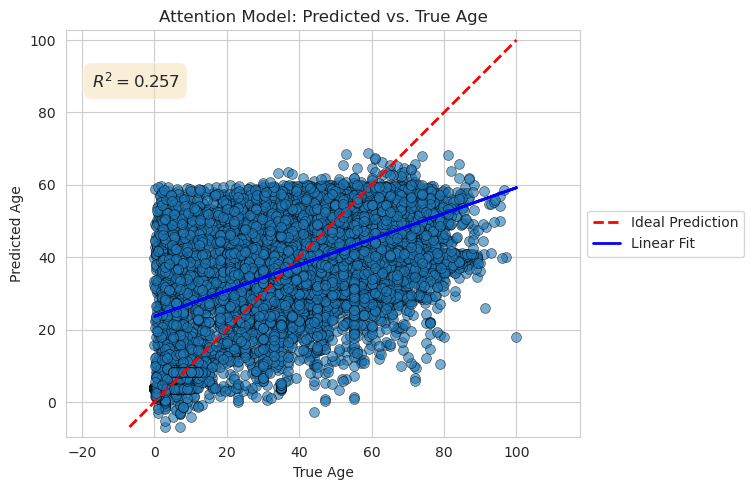

In [11]:
# --- 绘图 ---
plt.figure(figsize=(6, 5))
plt.scatter(y_true_attention, y_pred_attention, alpha=0.6, s=50, edgecolors='k', linewidths=0.5)

# 绘制理想预测线 (y=x)
min_val = min(y_true_attention.min(), y_pred_attention.min())
max_val = max(y_true_attention.max(), y_pred_attention.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction')


m, b = np.polyfit(y_true_attention, y_pred_attention, 1)
plt.plot(y_true_attention, m * y_true_attention + b, color='blue', lw=2, label='Linear Fit')

# 在图表上标注 R2 分数
# 使用 f-string 格式化 R2 值为小数点后三位
plt.text(0.05, 0.9, f'$R^2 = {r2_attention:.3f}$', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.title('Attention Model: Predicted vs. True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True)
plt.axis('equal') # 保证x轴和y轴的刻度等长
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

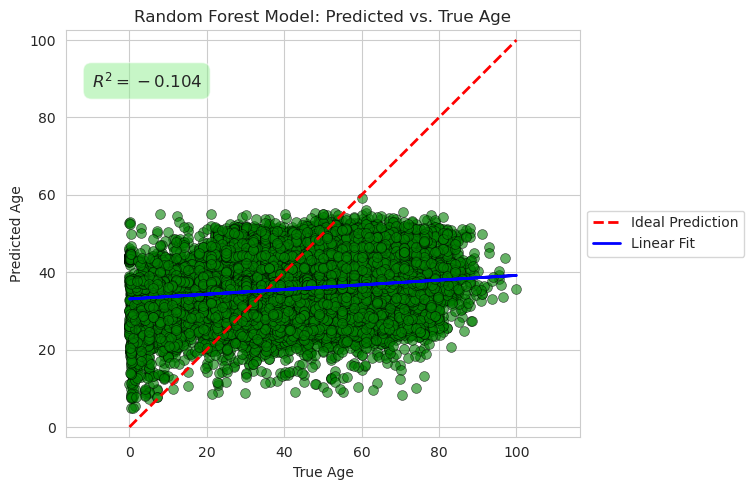

In [12]:
# --- 绘图 ---
plt.figure(figsize=(6, 5))
plt.scatter(y_true_rf, y_pred_rf, alpha=0.6, s=50, color='green', edgecolors='k', linewidths=0.5)

# 绘制理想预测线 (y=x)
min_val = min(y_true_rf.min(), y_pred_rf.min())
max_val = max(y_true_rf.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction')

m, b = np.polyfit(y_true_rf, y_pred_rf, 1)
plt.plot(y_true_rf, m * y_true_rf + b, color='blue', lw=2, label='Linear Fit')

# 在图表上标注 R2 分数
plt.text(0.05, 0.9, f'$R^2 = {r2_rf:.3f}$', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.5))

plt.title('Random Forest Model: Predicted vs. True Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.grid(True)
plt.axis('equal') # 保证x轴和y轴的刻度等长
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Attention Model R²: 0.257
Random Forest Model R²: -0.104


/tmp/ipykernel_153599/381061246.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


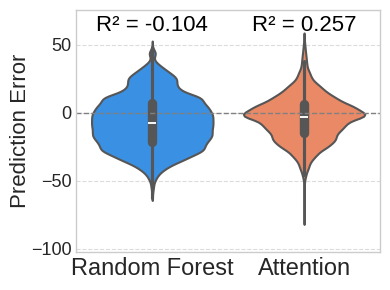

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

# Define file paths
attention_file = 'Data/age_prediction_data/all_studies_attention_predictions.csv'
rf_file = 'Data/age_prediction_data/all_studies_RF_predictions.csv'

# --- 1. Load Attention Model Data ---
try:
    attention_data = pd.read_csv(attention_file)
    y_true_attention = attention_data['TrueValue']
    y_pred_attention = attention_data['PredictedValue']
    r2_attention = r2_score(y_true_attention, y_pred_attention)
    print(f"Attention Model R²: {r2_attention:.3f}")
    attention_data['Prediction Error'] = (y_pred_attention - y_true_attention)
    attention_data['Model'] = 'Attention'
except FileNotFoundError:
    print(f"Error: {attention_file} not found. Please check the path.")
    attention_data = pd.DataFrame()
except Exception as e:
    print(f"Error reading {attention_file}: {e}")
    attention_data = pd.DataFrame()

# --- 2. Load Random Forest Model Data ---
try:
    rf_data = pd.read_csv(rf_file)
    y_true_rf = rf_data['TrueValue']
    y_pred_rf = rf_data['PredictedValue']
    r2_rf = r2_score(y_true_rf, y_pred_rf)
    print(f"Random Forest Model R²: {r2_rf:.3f}")
    rf_data['Prediction Error'] = (y_pred_rf - y_true_rf)
    rf_data['Model'] = 'Random Forest'
except FileNotFoundError:
    print(f"Error: {rf_file} not found. Please check the path.")
    rf_data = pd.DataFrame()
except Exception as e:
    print(f"Error reading {rf_file}: {e}")
    rf_data = pd.DataFrame()

# --- 3. Combine Data and Create Violin Plot ---
if not attention_data.empty or not rf_data.empty:
    # MODIFIED: Concatenate Random Forest data first to have it on the left
    combined_data = pd.concat([rf_data, attention_data], ignore_index=True)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(4, 3))

    sns.violinplot(
        x="Model",
        y="Prediction Error",
        data=combined_data,
        ax=ax,
        inner="box",
        # The order in the plot will now be determined by the order in combined_data
        # Alternatively, you could explicitly set: order=["Random Forest", "Attention"]
        palette={"Attention": "coral", "Random Forest": "dodgerblue"}, # Palette keys match model names
        linewidth=1.5,
        cut=0
    )

    y_min, y_max = ax.get_ylim()
    ax.set_ylim(top=y_max * 1.15, bottom=y_min * 1.15 if y_min < 0 else y_min * 0.85)

    annotation_y_position = ax.get_ylim()[1] * 0.95

    # MODIFIED: R² annotation for Random Forest (now on the left, x=0)
    if 'r2_rf' in locals() and not rf_data.empty:
        ax.text(0, annotation_y_position, f'R² = {r2_rf:.3f}', # x=0 for the first model (Random Forest)
                ha='center', va='top', fontsize=16, color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.3'))

    # MODIFIED: R² annotation for Attention (now on the right, x=1)
    if 'r2_attention' in locals() and not attention_data.empty:
        ax.text(1, annotation_y_position, f'R² = {r2_attention:.3f}', # x=1 for the second model (Attention)
                ha='center', va='top', fontsize=16, color='black',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none', boxstyle='round,pad=0.3'))

    ax.set_title('', fontsize=18, pad=20)
    ax.set_xlabel("", fontsize=16, labelpad=5)
    ax.set_ylabel("Prediction Error", fontsize=16, labelpad=0)
    ax.tick_params(axis='x', labelsize=17)
    ax.tick_params(axis='y', labelsize=13)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.axhline(0, color='grey', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo data available to plot.")